In [1]:
import os
import cv2
import json
import tqdm
import math
import copy
import torch
import keras_ocr
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from transformers import *
from transformers import ViTModel
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, VisualBertModel
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

c:\Users\Francesco De Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Francesco De Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\Francesco De Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
c:\Users\Francesco De Luca\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerati

#### METODI DI UTILITA'

In [ ]:
def apri_json(file_path):

    json_records = []

    with open(file_path, "r") as file:
        for line in file:
            json_record = json.loads(line.strip())
            json_records.append(json_record)

    return pd.DataFrame(json_records)


def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

def inpaint_text(img_path, pipeline):

    img = keras_ocr.tools.read(img_path)
    pipeline = keras_ocr.pipeline.Pipeline()
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return(img)

#### DATASET

In [2]:
class MemeDataset(Dataset):
    def __init__(self, data_path, image_folder, transform=None):
        self.data = []
        self.image_folder = image_folder
        self.transform = transform

        # Carica i dati dal file JSON
        with open(data_path, "r") as f:
            for line in f:
                entry = json.loads(line)
                self.data.append(entry)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        img_name = os.path.join(self.image_folder, entry["img"])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        text = entry["text"]
        label = entry["label"]

        return image, text, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona l'immagine a 224x224 pixel
    transforms.ToTensor(),          # Converti l'immagine in un tensore
    transforms.Lambda(lambda x: (x - torch.min(x))/(torch.max(x) - torch.min(x))),  # Normalizza i valori dei pixel
])


#### PARAMETRI

In [3]:
# Iperparametri
learning_rate = 1e-3
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_file = 'clip_cross'
train_path = "train_set_bilanciato.jsonl"
test_path = "test_set.jsonl"
image_folder = "notextimage/"
batch_size = 32

#### MODELLO:

In [4]:
class CLIPClassifier(pl.LightningModule):

    def __init__(self, head='cross', freeze_image_encoder=True, freeze_text_encoder=True):
        super().__init__()
        self.head = head
        self.map_dim = 32
        self.freeze_image_encoder = freeze_image_encoder
        self.freeze_text_encoder = freeze_text_encoder

        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

        self.clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.image_encoder = copy.deepcopy(self.clip.vision_model)
        self.text_encoder = copy.deepcopy(self.clip.text_model)

        self.image_map = nn.Sequential(
            copy.deepcopy(self.clip.visual_projection),
            nn.ReLU(),
            nn.Linear(self.clip.projection_dim, self.map_dim)
            )
        self.text_map = nn.Sequential(
            copy.deepcopy(self.clip.text_projection),
            nn.ReLU(),
            nn.Linear(self.clip.projection_dim, self.map_dim)
            )

        if self.head == 'concat':
            pre_output_input_dim = self.map_dim*2
        elif self.head == 'cross':
            pre_output_input_dim = self.map_dim**2

        pre_output_layers = [nn.Dropout(p=0.4)]
        output_input_dim = pre_output_input_dim

        pre_output_layers.extend([nn.Linear(pre_output_input_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=0.1)])
        output_input_dim = self.map_dim
        self.pre_output = nn.Sequential(*pre_output_layers)
        self.output = nn.Linear(output_input_dim, 1)
        
        self.cross_entropy_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')

        if self.freeze_image_encoder:
            for _, p in self.image_encoder.named_parameters():
                p.requires_grad_(False)

        if self.freeze_text_encoder:
            for _, p in self.text_encoder.named_parameters():
                p.requires_grad_(False)

        del self.clip

    def forward(self, image, text):
        p_out = self.processor(images = image, return_tensors="pt")
        p_out = p_out.to("cuda")
        image_features = self.image_encoder(pixel_values=p_out["pixel_values"]).pooler_output
        image_features = self.image_map(image_features)

        t_out = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        t_out = t_out.to("cuda")
        text_features = self.text_encoder(input_ids=t_out["input_ids"], attention_mask=t_out['attention_mask']).pooler_output
        text_features = self.text_map(text_features)

        image_features = F.normalize(image_features, p=2, dim=1)
        text_features = F.normalize(text_features, p=2, dim=1)

        if self.head == 'concat':
            features = torch.cat([image_features, text_features], dim=1)
        elif self.head == 'cross':
            features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1)) # [b, d, d]
            features = features.reshape(features.shape[0], -1)  # [b, d*d]

        features = self.pre_output(features)
        logits = self.output(features)
        #preds = (torch.sigmoid(logits) >= 0.5).long()

        return logits

##### ADDESTRAMENTO

In [ ]:
def train_model(model, scheduler, train_dataloader, criterion, optimizer, epochs, device, model_file):
    model.train()
    min_loss = float("inf")
    for epoch in range(epochs):
        epoch_loss = 0.0

        pbar = tqdm(train_dataloader)
        for _, (image, text, label) in enumerate(pbar):

            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = model(image, text)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            pbar.set_postfix(Loss=loss.item())
            epoch_loss += loss.item()
        scheduler.step()
        epoch_loss /= len(train_dataloader)
        if epoch_loss < min_loss :
            min_loss = epoch_loss
            print(f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}")
            torch.save(model.state_dict(), f"{model_file}.pt")

In [9]:
model = CLIPClassifier()
model.to(device)

dataset = MemeDataset(train_path, image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.95)

loading configuration file preprocessor_config.json from cache at C:\Users\Francesco De Luca/.cache\huggingface\hub\models--openai--clip-vit-large-patch14\snapshots\32bd64288804d66eefd0ccbe215aa642df71cc41\preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}), got 224. Converted to {'shortest_edge': 224}.
crop_size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor

In [10]:
train_model(model, scheduler, dataloader, criterion, optimizer, epochs, device, model_file)

100%|██████████| 191/191 [15:02<00:00,  4.73s/it, Loss=0.606]


Loss at epoch 1: 0.622


100%|██████████| 191/191 [13:43<00:00,  4.31s/it, Loss=0.637]


Loss at epoch 2: 0.552


100%|██████████| 191/191 [13:01<00:00,  4.09s/it, Loss=0.631]


Loss at epoch 3: 0.510


100%|██████████| 191/191 [12:48<00:00,  4.02s/it, Loss=0.529]


Loss at epoch 4: 0.460


100%|██████████| 191/191 [12:35<00:00,  3.96s/it, Loss=0.285]


Loss at epoch 5: 0.409


100%|██████████| 191/191 [12:31<00:00,  3.94s/it, Loss=0.492]


Loss at epoch 6: 0.361


100%|██████████| 191/191 [12:39<00:00,  3.97s/it, Loss=0.515]


Loss at epoch 7: 0.321


100%|██████████| 191/191 [12:41<00:00,  3.99s/it, Loss=0.287]


Loss at epoch 8: 0.287


100%|██████████| 191/191 [12:40<00:00,  3.98s/it, Loss=0.412]


Loss at epoch 9: 0.275


100%|██████████| 191/191 [12:40<00:00,  3.98s/it, Loss=0.318] 


Loss at epoch 10: 0.251


100%|██████████| 191/191 [12:42<00:00,  3.99s/it, Loss=0.177]


Loss at epoch 11: 0.232


100%|██████████| 191/191 [12:40<00:00,  3.98s/it, Loss=0.413] 


Loss at epoch 12: 0.228


100%|██████████| 191/191 [12:31<00:00,  3.93s/it, Loss=0.143] 


Loss at epoch 13: 0.211


100%|██████████| 191/191 [12:38<00:00,  3.97s/it, Loss=0.172] 


Loss at epoch 14: 0.209


100%|██████████| 191/191 [12:38<00:00,  3.97s/it, Loss=0.259] 


Loss at epoch 15: 0.200


100%|██████████| 191/191 [12:31<00:00,  3.94s/it, Loss=0.183] 


Loss at epoch 16: 0.199


100%|██████████| 191/191 [12:29<00:00,  3.92s/it, Loss=0.106] 


Loss at epoch 17: 0.190


100%|██████████| 191/191 [12:28<00:00,  3.92s/it, Loss=0.17]  


Loss at epoch 18: 0.186


100%|██████████| 191/191 [12:29<00:00,  3.92s/it, Loss=0.147] 


Loss at epoch 19: 0.185


100%|██████████| 191/191 [12:29<00:00,  3.92s/it, Loss=0.11]  


Loss at epoch 20: 0.184


100%|██████████| 191/191 [12:29<00:00,  3.92s/it, Loss=0.217] 


Loss at epoch 22: 0.181


100%|██████████| 191/191 [12:35<00:00,  3.95s/it, Loss=0.218] 


Loss at epoch 23: 0.178


100%|██████████| 191/191 [12:41<00:00,  3.99s/it, Loss=0.182] 


Loss at epoch 24: 0.177


100%|██████████| 191/191 [12:38<00:00,  3.97s/it, Loss=0.08]  


Loss at epoch 25: 0.175


100%|██████████| 191/191 [12:41<00:00,  3.99s/it, Loss=0.194] 


Loss at epoch 26: 0.173


100%|██████████| 191/191 [12:39<00:00,  3.98s/it, Loss=0.176] 


Loss at epoch 29: 0.170


100%|██████████| 191/191 [12:39<00:00,  3.98s/it, Loss=0.000608]


Loss at epoch 30: 0.170


100%|██████████| 191/191 [12:45<00:00,  4.01s/it, Loss=0.208] 


Loss at epoch 31: 0.169


100%|██████████| 191/191 [12:43<00:00,  4.00s/it, Loss=0.158] 


Loss at epoch 33: 0.169


100%|██████████| 191/191 [12:32<00:00,  3.94s/it, Loss=0.0997]


Loss at epoch 34: 0.167


100%|██████████| 191/191 [12:31<00:00,  3.93s/it, Loss=0.0644]


Loss at epoch 35: 0.166


100%|██████████| 191/191 [12:30<00:00,  3.93s/it, Loss=0.249] 


Loss at epoch 36: 0.166


100%|██████████| 191/191 [12:31<00:00,  3.93s/it, Loss=0.359] 


Loss at epoch 37: 0.165


100%|██████████| 191/191 [12:33<00:00,  3.94s/it, Loss=0.146] 


Loss at epoch 38: 0.164


100%|██████████| 191/191 [12:32<00:00,  3.94s/it, Loss=0.296] 


Loss at epoch 39: 0.164


 31%|███▏      | 60/191 [04:01<08:48,  4.03s/it, Loss=0.284] 


KeyboardInterrupt: 

In [5]:
# Eval
model = CLIPClassifier()
model.load_state_dict(torch.load(f"{model_file}.pt"))
model.to(device)
model.eval()

loading configuration file preprocessor_config.json from cache at C:\Users\Francesco De Luca/.cache\huggingface\hub\models--openai--clip-vit-large-patch14\snapshots\32bd64288804d66eefd0ccbe215aa642df71cc41\preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}), got 224. Converted to {'shortest_edge': 224}.
crop_size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor

CLIPClassifier(
  (image_encoder): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-23): 24 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=

In [6]:
dataset_test = MemeDataset(test_path , image_folder, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

pred_labels = []
labels = []
prob = []

pbar = tqdm(dataloader_test)
for step, (image, text, label) in enumerate(pbar):

    image = image.to(device)
    label = label.to(device)

    output = model(image, text)
    prob.append(output.cpu().detach().numpy()[0])
    predictions = (output.cpu().detach().numpy() > 0.5).astype(int)
    pred_labels.extend(predictions[0])
    labels.extend(label.cpu().detach().numpy())

100%|██████████| 500/500 [01:34<00:00,  5.31it/s]


In [13]:
p = 0
n = 0
for i in pred_labels:
    if i == 0:
        p+=1
    else:
        n+=1
print(p, n)

296 204


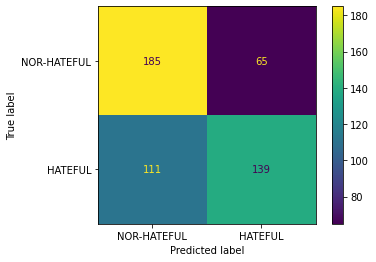

In [10]:
confusion_matrixx = confusion_matrix(labels, pred_labels)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrixx, display_labels = ["NOR-HATEFUL", "HATEFUL"])

cm_display.plot()
plt.savefig(f"{model_file}.jpg")
plt.show()

report = classification_report(labels, pred_labels, output_dict = True )
df = pd.DataFrame(report).transpose()
df.to_json(f"{model_file}.csv")

In [8]:
print(classification_report(labels, pred_labels ))

              precision    recall  f1-score   support

           0       0.62      0.74      0.68       250
           1       0.68      0.56      0.61       250

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.64       500
weighted avg       0.65      0.65      0.64       500



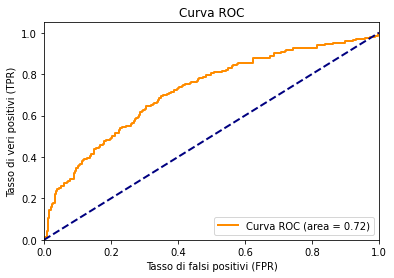

In [9]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(labels, prob)

# Calcolo dell'AUC
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasso di falsi positivi (FPR)')
plt.ylabel('Tasso di veri positivi (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()